# This is an Adversarial Example

We try to fool the network with some random noise to understant what happens in the neural net

<img src="Capture2.JPG"></img>

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [44]:
pretrained_model=tf.keras.applications.MobileNetV2(include_top=True,weights="imagenet")

14540800/14536120 [==============================] - 2s 0us/step


In [45]:
pretrained_model.trainable=False

In [46]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [47]:
decode_prediction=tf.keras.applications.mobilenet_v2.decode_predictions

In [48]:
preprocess=tf.keras.applications.mobilenet_v2.preprocess_input

In [49]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)


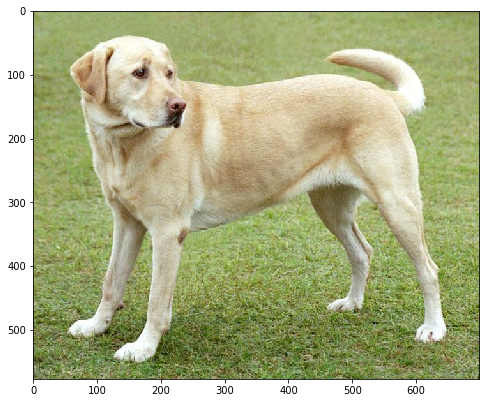

In [50]:
plt.imshow(image)

In [51]:
image=tf.cast(image,tf.float32)

In [52]:
image_process=preprocess(image)

In [53]:
image_process=tf.image.resize(image_process,[224,224])

In [56]:
out=pretrained_model.predict(tf.expand_dims(image_process,axis=0))

In [57]:
out.shape

(1, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'ClassLabrador_retriever  0.42% confidence')

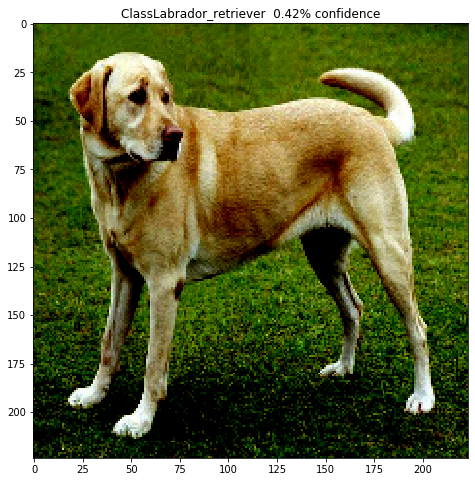

In [90]:
x,y,z=decode_prediction(out,top=1)[0][0]
plt.imshow(image_process)
plt.title("Class{}  {:.2f}% confidence".format(y,z*100))

# Create an Adversarial image


In [86]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss,input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


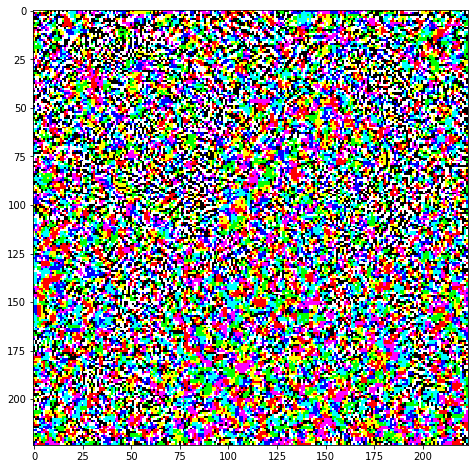

In [87]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, out.shape[-1])
label = tf.reshape(label, (1, out.shape[-1]))

perturbations = create_pattern(tf.expand_dims(image_process,axis=0), label)
plt.imshow(perturbations[0])


In [98]:
def display_image(image,description):
    x,y,z=decode_prediction(pretrained_model.predict(image),top=1)[0][0]
    plt.imshow(image[0])
    plt.title("Class{}  {:.2f}% confidence {}".format(y,z*100,description))
    plt.show()

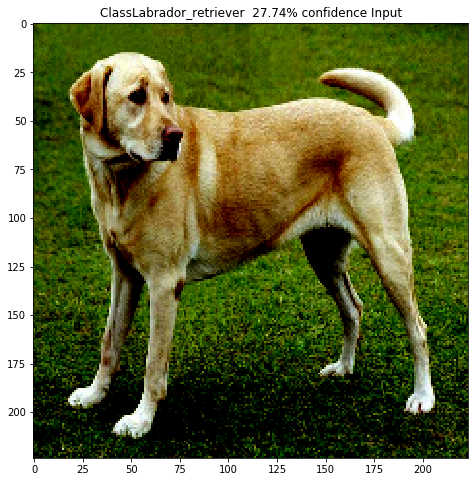

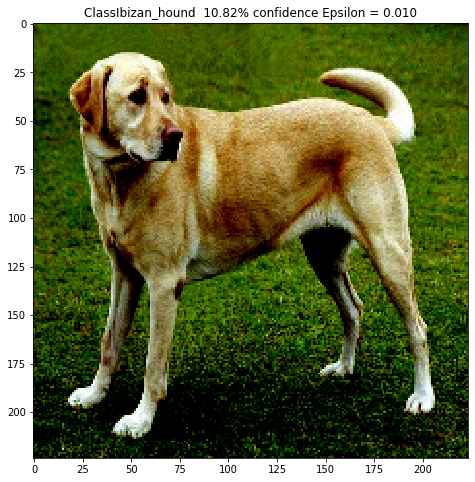

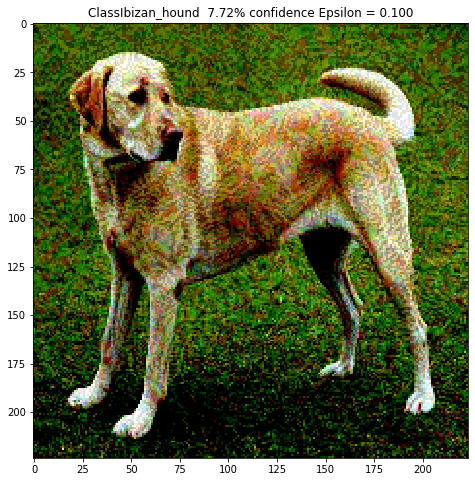

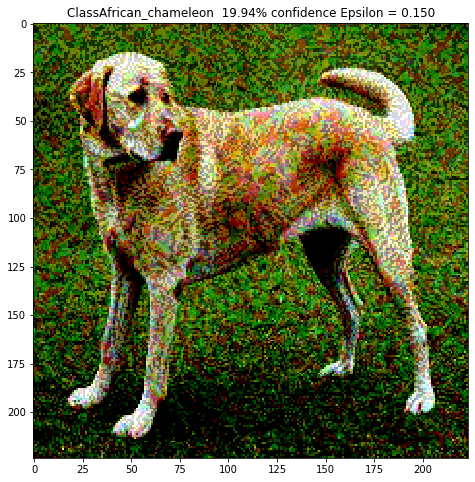

In [99]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image_process + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_image(adv_x, descriptions[i])
